# Project ML

In [1]:
!pip install import-ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/ML2022/ProjectML

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/MyDrive/ML2022/ProjectML'
/content/gdrive/MyDrive/ML2022/ProjectML


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import random

import import_ipynb
import utils1
import utils2
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
import torchtext

from sklearn.feature_extraction.text import CountVectorizer

# to get reproducible results:
torch.manual_seed(7)
np.random.seed(7)

importing Jupyter notebook from utils1.ipynb
importing Jupyter notebook from utils2.ipynb


## Loading and splitting data

In [ ]:
wineDf = pd.read_csv("data/wineReviews.csv", usecols=['Reviews Rating', 'Reviews Text'])
pd.set_option('display.max_colwidth', None)
wineDf.columns = ['Rating', 'Review']
wineDf.loc[1]

Rating                                                 5.0
Review    Tart, not sweet...very refreshing and delicious!
Name: 1, dtype: object

In [ ]:
wineDf = wineDf.dropna(subset=['Review'])[['Review','Rating']]
wineDf = wineDf.dropna(subset=['Rating'])[['Review','Rating']]
wineDf.shape, wineDf.isnull().sum()

((2444, 2), Review    0
 Rating    0
 dtype: int64)

In [ ]:
from sklearn.model_selection import train_test_split

y = wineDf.Rating
X = wineDf.Review
x_train, x_dev_test, y_train, y_dev_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=7)
x_dev, x_test, y_dev, y_test = train_test_split(x_dev_test, y_dev_test, stratify=y_dev_test, test_size=0.5, random_state=7)

In [ ]:
print(x_train.shape)
print(x_dev.shape)
print(x_test.shape)

print(y_train.shape)
print(y_dev.shape)
print(y_test.shape)

(1955,)
(244,)
(245,)
(1955,)
(244,)
(245,)


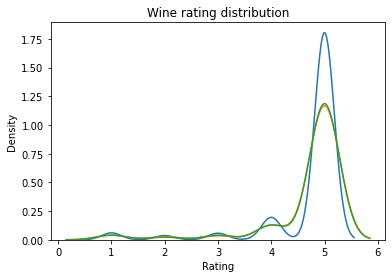

In [ ]:
#rates well stratified?
ax = sns.kdeplot(y_train, label='train')
sns.kdeplot(y_dev, ax=ax, label='dev');
sns.kdeplot(y_test, ax=ax, label='test');
plt.title('Wine rating distribution')
plt.ylabel('Density');
plt.xlabel('Rating');

#LINEAR MODEL

In [ ]:
########TRIED LINEAR MODEL ####### 
# vectorize sequences and make them numpy arrays

vect = CountVectorizer(binary=True)
vect.fit(x_train)
x_train_mat = vect.transform(x_train)
x_train_vec = np.asarray(x_train_mat.todense())
x_dev_vec = np.asarray(vect.transform(x_dev).todense())
x_test_vec = np.asarray(vect.transform(x_test).todense())
y_train = np.asarray(y_train)
y_dev = np.asarray(y_dev)
y_test = np.asarray(y_test)

print(x_train_vec.shape)
print(x_dev_vec.shape)
print(x_test_vec.shape)

print(y_train.shape)
print(y_dev.shape)
print(y_test.shape)

num_words = x_train_vec.shape[1]

#TEST do these vectors really represent a correct review?
# review_words = vect.get_feature_names_out()
# print(type(review_words))
#testreview = pd.DataFrame(x_train_mat.todense(), columns=review_words).loc[1].to_numpy().nonzero()
#for word in testreview[0]:
#  print(word)
#  print(review_words[word])

#test = "Based on positive reviews, I served all of the Fancy Pants varieties at a recent party. My guests and I loved them! Since I am not a wine expert, I will provide some details on this variety from the Fancy Pants website: ...is like sunshine in the glass. Its brisk and bright, with inviting citrus, melon and passion fruit aromas leading to mouthwatering grapefruit and zesty lime flavors with hints of minerality on the palate. Vibrant acidity and a crisp, clean finish make this wine a versatile partner for a wide range of foodsespecially succulent seafood, Mediterranean-style grilled vegetables, and salads. Served well chilled, our Sauvignon Blanc is fun and friendlythe perfect pour for sunny afternoons and picnics."

NameError: ignored

In [ ]:
#Transforming to torch classes
#For linear regression we expand the dim of y

def np2iter(x, y, shuffle=True):
  x = torch.tensor(x, dtype=torch.float)
  y = np.expand_dims(y, axis=1)
  y = torch.tensor(y, dtype=torch.float)
  print(y.shape)

  ds = torch.utils.data.TensorDataset(x, y)
  return torch.utils.data.DataLoader(ds, batch_size=32, shuffle=shuffle)

train_iter = np2iter(x_train_vec, y_train, shuffle=True)
dev_iter = np2iter(x_dev_vec, y_dev, shuffle=False)
test_iter = np2iter(x_test_vec, y_test, shuffle=False)

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score


def accuracy_from_floats(y_true, y_pred):
  # print(f'type of y_true: {type(y_true)} /n type of y_pred: {type(y_pred)}' )
  # print(f'value of y_true: {y_true} /n value of y_pred: {y_pred}')
  y_pred = np.around(y_pred).astype(float)
  return accuracy_score(y_true, y_pred)


In [ ]:
# #DEFINE DIFFERENT MODELS
# #LINEAR MODEL 1 LAYER

class DeepModel1(nn.Module):
  def __init__(self, in_features=num_words, out_features=1):
    super(DeepModel1, self).__init__()
    self.layer = nn.Sequential(nn.Linear(in_features=in_features, out_features=500), 
                                nn.ReLU(),
                                nn.Linear(in_features=500, out_features=out_features))

  def forward(self, x):
    return self.layer(x)


In [ ]:
# #TRAIN FIRST LINEAR REGRESSION MODEL


reg_model = DeepModel1(in_features=num_words, out_features=1)
reg_model = reg_model.cuda()

history = utils1.train(model=reg_model,
                loss=nn.MSELoss(),
                optimizer=torch.optim.SGD(reg_model.parameters(), lr=0.001),
                train_ds=train_iter, 
                dev_ds=dev_iter,
                val_metrics = {"mse": nn.MSELoss()},
                early_stopper=utils1.EarlyStopper(metric_name="mse", patience=5),
                num_epochs=300)

reg_predictions = utils1.test(reg_model, test_iter)


In [ ]:
y_pred_arr = reg_predictions.numpy()

print("-----MSE------")
print(mse(y_pred=y_pred_arr, y_true=y_test))
print("-----MAE------")
print(mae(y_pred=y_pred_arr, y_true=y_test))
print("-----ACC------") 
print(accuracy_from_floats(y_pred=y_pred_arr, y_true=y_test))

plt.plot(history["train_loss"], label='train')
plt.plot(history["val_mse"], label='val')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE');
plt.legend()

#accuracy lower than majority baseline: 0.8371987266939518

In [ ]:
sns.kdeplot(y_pred_arr.squeeze())
plt.xlabel('predictions test set')
plt.title('Distribution of predicted y after training')
plt.xlim((0, 6));

In [ ]:
# #It is logical that the linear regression model would not assign lower rates because there are no classes, and a higher rate is more often correct
from sklearn.metrics import classification_report
print(classification_report(y_pred=np.around(y_pred_arr).astype(float), y_true=y_test))

In [ ]:
#import copy
# def get_weights(model):
#   w = model.layer.weight.numpy()
#   b = model.layer.bias.numpy()
#   return copy.deepcopy(w), copy.deepcopy(b)

# get_weights(linear_model)

# LOGISTIC REGRESSION

Came with errors I could not solve...

In [ ]:
# #Do they have to have a different datatype? In other excercises the datatype of the vectors are always float, but I don't know why

# print(x_train_vec.shape)
# print(x_dev_vec.shape)
# print(x_test_vec.shape)

# print(y_train.shape)
# print(y_dev.shape)
# print(y_test.shape)

(1955, 4632)
(244, 4632)
(245, 4632)
(1955,)
(244,)
(245,)


In [ ]:
# print(max(y_train))
# max(y_dev)
# max(y_test)
# np.unique(y_train)

In [ ]:
# #Transforming to torch classes
# #For classification we don't need to expand the dimension

# def np2iter(x, y, shuffle=True):
#   x = torch.tensor(x, dtype=torch.float)
#   y = torch.tensor(y, dtype=torch.long)
#   ds = torch.utils.data.TensorDataset(x, y)
#   return torch.utils.data.DataLoader(ds, batch_size=32, shuffle=shuffle)

# train_iter2 = np2iter(x_train_vec, y_train, shuffle=True)
# dev_iter2 = np2iter(x_dev_vec, y_dev, shuffle=False)
# test_iter2 = np2iter(x_test_vec, y_test, shuffle=False)

# num_words = x_train_vec.shape[1]
# num_words

4632

In [ ]:
#Standard classification SGD model
#Here an error occurs, no idea why. 

# model2 = DeepModel1(in_features=num_words, out_features=5)
# model2 = model2.cuda()


# def val_acc(y_pred, y_test):
#   print(y_pred)
#   print(y_test)
#   y_pred = np.argmax(y_pred, axis=1)
#   return accuracy_score(y_pred=y_pred, y_true=y_test)

# history = utils1.train(model=model2,
#                             loss=nn.CrossEntropyLoss(),
#                             val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc}, 
#                             optimizer=torch.optim.SGD(model2.parameters(), lr=0.001),
#                             train_ds=train_iter2, 
#                             dev_ds=dev_iter2,
#                             early_stopper=utils1.EarlyStopper(metric_name="cls", patience=5),
#                             num_epochs=15)



NameError: ignored

-----MSE------
0.5213376998628533
-----MAE------
0.46141332509566324
-----ACC------
0.710204081632653


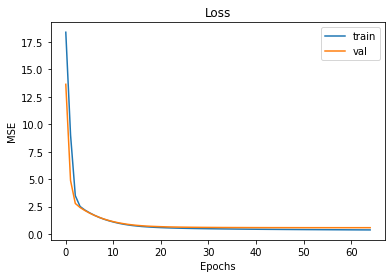

In [ ]:
# y_pred_arr = reg_predictions.numpy()
# print("-----MSE------")
# print(mse(y_pred=y_pred_arr, y_true=y_test))
# print("-----MAE------")
# print(mae(y_pred=y_pred_arr, y_true=y_test))
# print("-----ACC------")
# print(val_acc(y_pred=y_pred_arr, y_true=y_test))

# plt.plot(history["train_loss"], label='train')
# plt.plot(history["val_cls"], label='val')
# plt.title('Loss')
# plt.xlabel('Epochs')
# plt.ylabel('CLS');
# plt.legend()

#RNN

##PREPROCESSING

In [ ]:
#CHANGE NUMWORDS TO MORE IF WORKS
from keras.preprocessing.text import Tokenizer
num_words = 3000
tokenizer = Tokenizer(num_words = 3000, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

In [ ]:
word_index = tokenizer.word_index
train_data = tokenizer.texts_to_sequences(x_train)
dev_data= tokenizer.texts_to_sequences(x_dev)
test_data = tokenizer.texts_to_sequences(x_test)



In [ ]:
num_classes = len(y_train.unique())
num_classes

5

In [ ]:
max_len = 200

from torch.nn.utils.rnn import pad_sequence

train_data = [sent[:max_len] for sent in train_data]
dev_data = [sent[:max_len] for sent in dev_data]
test_data = [sent[:max_len] for sent in test_data]
print(len(train_data))
print(len(test_data))


x_train_padded = pad_sequence([torch.tensor(sent) for sent in train_data], batch_first=True)
x_dev_padded = pad_sequence([torch.tensor(sent) for sent in dev_data], batch_first=True)
x_test_padded = pad_sequence([torch.tensor(sent) for sent in test_data], batch_first=True)
print(x_train_padded.shape)
print(x_dev_padded.shape)
print(x_test_padded.shape)

1955
245
torch.Size([1955, 200])
torch.Size([244, 200])
torch.Size([245, 200])


In [ ]:
# from keras.datasets import imdb 
# # (imbdx, imbdy), (imbdtestx, imbdtesty) = imdb.load_data(num_words=num_words)
# print(type(imbdy))
# print(imbdy[0])
# npy_train = 
# print(type(npy_train))
# print(npy_train[0])

#We need numpy arrays
y_train_np = y_train.to_numpy()
y_dev_np = y_dev.to_numpy()
y_test_np = y_test.to_numpy()


def np2iter(x, y, shuffle=True):
  y = torch.tensor(y, dtype=torch.long)
  print(x.shape)
  print(y.shape)
  ds = torch.utils.data.TensorDataset(x, y)
  return torch.utils.data.DataLoader(ds, batch_size=32, shuffle=shuffle)

train_iter = np2iter(x_train_padded, y_train_np, shuffle=True)
dev_iter =  np2iter(x_dev_padded, y_dev_np, shuffle=False)
test_iter =  np2iter(x_test_padded, y_test_np, shuffle=False)

torch.Size([1955, 200])
torch.Size([1955])
torch.Size([244, 200])
torch.Size([244])
torch.Size([245, 200])
torch.Size([245])


##Train without pre-trained embedding

In [ ]:
def val_acc(y_pred, y_test):
  y_pred = np.argmax(y_pred, axis=1)
  return accuracy_score(y_pred=y_pred, y_true=y_test)

In [ ]:
class AverageModel(nn.Module):
  def __init__(self, emb_dim=50):
    super(AverageModel, self).__init__()

    self.embeddings = nn.Embedding(num_embeddings=num_words, 
                                   embedding_dim=emb_dim, padding_idx=0)
    
    self.layer = nn.Sequential(nn.Linear(in_features=emb_dim, out_features=emb_dim), 
                                nn.ReLU(),
                                nn.Linear(in_features=emb_dim, out_features=num_classes))
    

  def forward(self, x):
    mask = x != 0
    x = self.embeddings(x)
    x = x.sum(dim=1)/mask.sum(dim=1,  keepdim=True)
    return self.layer(x)

    #when we calculate average we shouldn't include padding (> so we mask out our zero's)

In [ ]:
average_model = AverageModel(emb_dim=50)

average_model = average_model.cuda()

history = utils2.train(model=average_model,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc}, 
              optimizer=torch.optim.Adam(average_model.parameters(), lr=0.0001),
              train_ds=train_iter, 
              dev_ds=dev_iter,
              num_epochs=20,
              early_stopper=utils2.EarlyStopper(metric_name="cls", patience=3))

RuntimeError: ignored

# Weights regularization

In [ ]:
#DOES this help with our recall problem?
model5 = DeepModel2()
model5 = model5.cuda()

history = utils.train(model=model5,
                            loss=nn.CrossEntropyLoss(),
                            l2_regularization=utils.L2Regularization(0.05),
                            val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc}, 
                            optimizer=torch.optim.Adam(model5.parameters(), lr=5e-4),
                            train_ds=train_iter2, 
                            dev_ds=dev_iter2,
                            num_epochs=20)

In [ ]:
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Embedded model

In [ ]:
class FlatModel(nn.Module):
  def __init__(self, emb_dim=50):
    super(FlatModel, self).__init__()

    self.embeddings = nn.Embedding(num_embeddings=num_words, 
                                   embedding_dim=emb_dim, padding_idx=0)
    
    self.layer = nn.Sequential(nn.Linear(in_features=emb_dim*max_len, out_features=emb_dim), 
                                nn.ReLU(),
                                nn.Linear(in_features=emb_dim, out_features=2))
    

  def forward(self, x):
    x = self.embeddings(x)
    x = torch.flatten(x, start_dim=1, end_dim=- 1)
    return self.layer(x)

In [ ]:
class AverageModel(nn.Module):
  def __init__(self, emb_dim=50):
    super(AverageModel, self).__init__()

    self.embeddings = nn.Embedding(num_embeddings=num_words, 
                                   embedding_dim=emb_dim, padding_idx=0)
    
    self.layer = nn.Sequential(nn.Linear(in_features=emb_dim, out_features=emb_dim), 
                                nn.ReLU(),
                                nn.Linear(in_features=emb_dim, out_features=2))
    

  def forward(self, x):
    # later we are going to mask zeros in the input to calculate average
    mask = x != 0
    x = self.embeddings(x)
    x = x.sum(dim=1)/mask.sum(dim=1,  keepdim=True)
    return self.layer(x)